## Общая информация
Мобильная игра зарабатывает на показе рекламы. Есть несколько форматов:
**int** – полноэкранная реклама; **banner** – горизонтальный баннер, висит внизу экрана пока юзер играет; **rv** – видео, которое юзер смотрит по желанию и за просмотр получает монетки или др. ресурсы. Информация о каждом показе отправляется в аналитику и содержит доход от показа, формат показанной рекламы, рекламную сеть от которой был показ и др. **eCPM** – доход за 1000 показов рекламы.


## Бизнес задача
Провести исследование показов рекламы с целью понять на сколько отличается eCPM в зависимости от географии (города) юзера, версии ОС и других параметров. Интересны любые инсайты и находки по eCPM-ам.

## Что требуется
1. Для каждого формата рекламы:
    1. построить распределение средних eCPM-ов юзеров
    2. отобразить средние eCPM-мы по городам, версиям ОС
    3. отобразить суммарные доходы по городам, версиям ОС
2. Учесть статистическую значимость (отобразить, отфильтровать незначимое или хотя бы прокомментировать). Объяснить решение.
3. Описать наблюдения и вывод по исследованию.   

## Дополнительные (по желанию)
Исследовать:
- Какой процент доходов содержит информацию о городе юзера
- Зависит ли eCPM от времени дня   

## Вспомогательная информация   

Столбец **profile_id** – id юзера
Столбец **event_json** содержит данные о событии показа рекламы:

**ad_type** – формат рекламы (int, banner или rv)

**placement** – когда/где был показ рекламы в игре

**view_index** – номер показа конкретного формата рекламы для юзера (не поддерживается для баннеров)

**revenue** – доход от конкретного показа рекламы (eCPM = revenue * 1000)

**ads_ltv** – накапливающийся доход от рекламы, равен сумме всех revenue юзера

**network_name** – рекламная сеть, от которой был показ
Остальные столбцы должны быть интуитивно понятны


In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
data = pd.read_csv('us events ad_revenue filtered 03.02-07.02.csv')
data.head()

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_json,event_datetime,event_timestamp,event_receive_datetime,event_receive_timestamp,connection_type,operator_name,country_iso_code,city
0,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:28,1643994148,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
1,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:45,1643994165,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
2,JLkVacrzHY6,11,Google,Pixel 2,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-05 17:53:05,1644072785,2022-02-06 16:59:29,1644155969,wifi,Verizon,US,Charlotte
3,JMC6wG3cX0f,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""int"",""placement"":""next_level"",""vie...",2022-02-06 17:09:01,1644156541,2022-02-06 17:09:24,1644156564,wifi,T-Mobile,US,Cocoa
4,JLzWWTJfi1b,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-06 17:15:38,1644156938,2022-02-06 17:16:16,1644156976,cell,Verizon,US,NaN


Посмотрим в каких столбцах отсутсвуют значения или значения неизвестны и посчитаем их количество

In [3]:
data.isnull().sum()[data.isnull().sum() != 0]

profile_id           14
operator_name     18879
city             323708
dtype: int64

#### 1.A. Построим распределение средних eCPM-ов юзеров для каждого формата рекламы.
Для этого создадим три таблицы:
- int_data, для этого нужно поставить условие event_json['ad_type'] == 'int'
- banner_data, ...
- rv_data, ...

Но для начала надо изменить тип string у значений в столбце event_json на dictionary, чтобы было проще работать, и вытащить все данные из словаря в таблицу

In [4]:
a = data['event_json'].loc[1]
print(type(a))
print(type(json.loads(a)))

<class 'str'>
<class 'dict'>


In [5]:
def str_to_json(s1):
    return json.loads(s1)

data['new_event_json'] = data['event_json'].apply(str_to_json)
for i in data['new_event_json'][0].keys():
    data[i] = data['new_event_json'].apply(lambda d: d[i])
    
data['time'] = data['event_datetime'].apply(lambda x: int(datetime.strptime(x, '%Y-%m-%d %H:%M:%S').time().hour))

In [6]:
int_data = data[data.ad_type == 'int']
banner_data = data[data.ad_type == 'banner']
rv_data = data[data.ad_type == 'rv']

Дальше необходимо для каждого юзера взять revenue из всех его сессий и подсчитать среднее. Из этих значений можно построить распределение средних eCPM-ов.

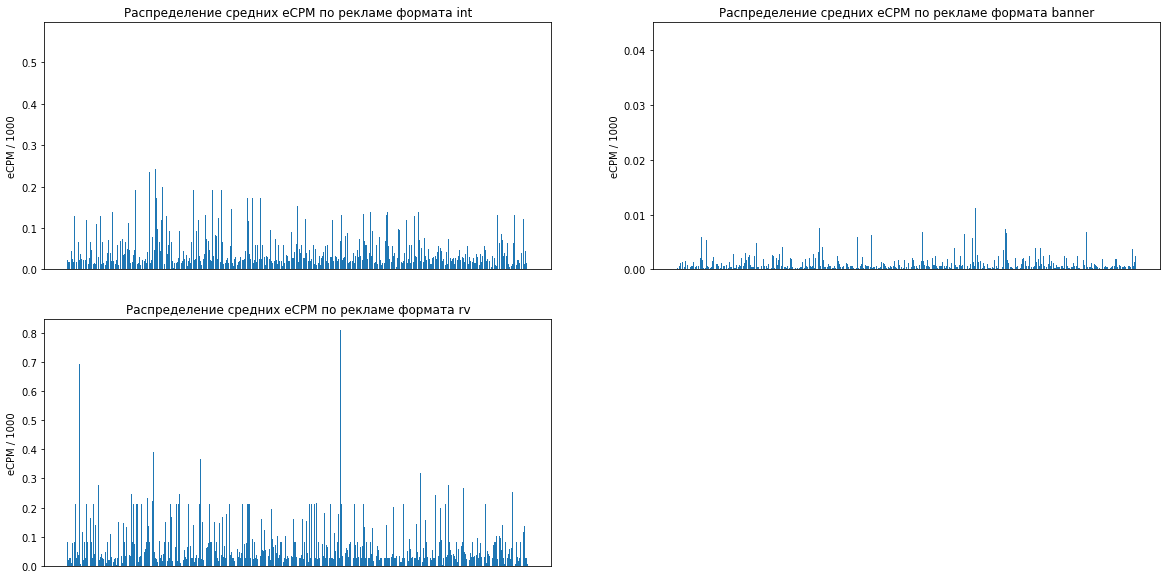

In [7]:
int_data_grouped_by_profile_id = int_data[['profile_id', 'revenue']].dropna().groupby('profile_id').mean('revenue')
banner_data_grouped_by_profile_id = banner_data[['profile_id', 'revenue']].dropna().groupby('profile_id').mean('revenue')
rv_data_grouped_by_profile_id = rv_data[['profile_id', 'revenue']].dropna().groupby('profile_id').mean('revenue')

x1 = int_data_grouped_by_profile_id.index
y1 = int_data_grouped_by_profile_id.revenue

x2 = banner_data_grouped_by_profile_id.index
y2 = banner_data_grouped_by_profile_id.revenue

x3 = rv_data_grouped_by_profile_id.index
y3 = rv_data_grouped_by_profile_id.revenue

fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)

ax1.set(title='Распределение средних eCPM по рекламе формата int', xticks=[], ylabel='eCPM / 1000')
ax1.bar(x1, y1)

ax2.set(title='Распределение средних eCPM по рекламе формата banner', xticks=[], ylabel='eCPM / 1000')
ax2.bar(x2, y2)

ax3.set(title='Распределение средних eCPM по рекламе формата rv', xticks=[], ylabel='eCPM / 1000')
ax3.bar(x3, y3)

plt.show()

#### 1.B. Отобразим средние eCPM-мы по городам и версиям ОС для каждого формата рекламы.   
Незначимые (неизвестные) данные будут исключены с помощью конструкции try - except, для них значения будут равны нулю

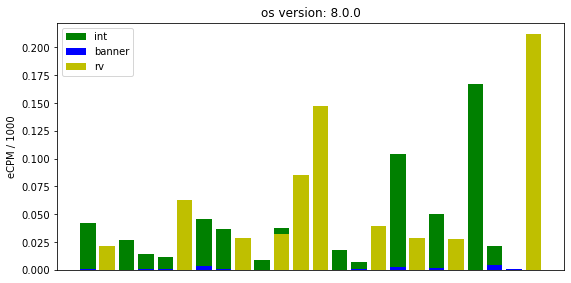

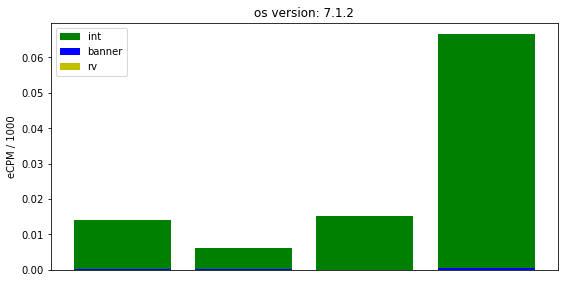

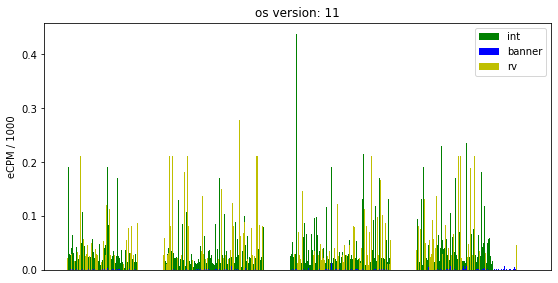

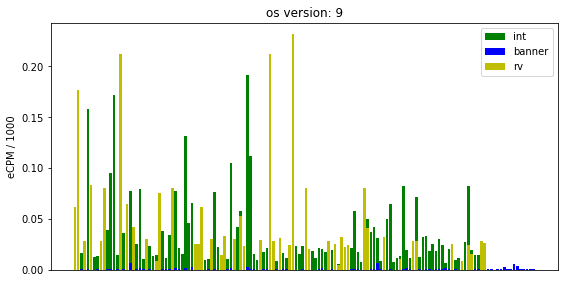

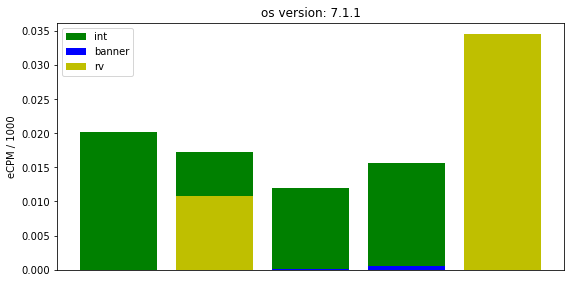

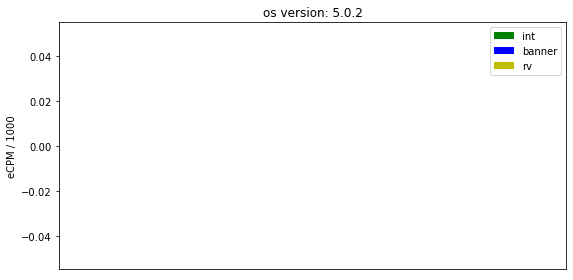

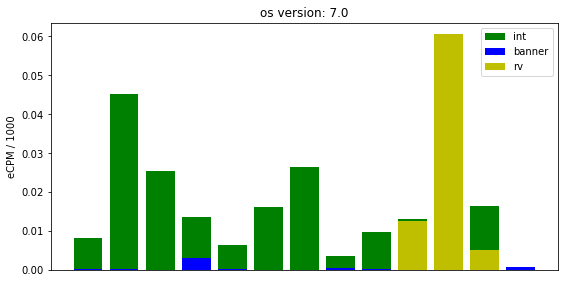

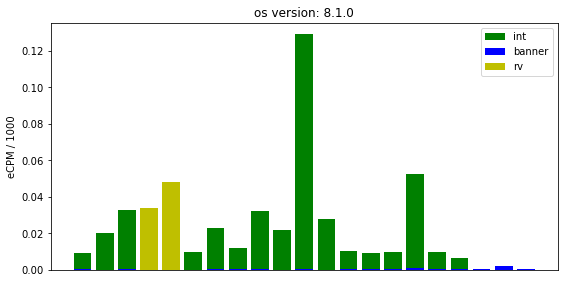

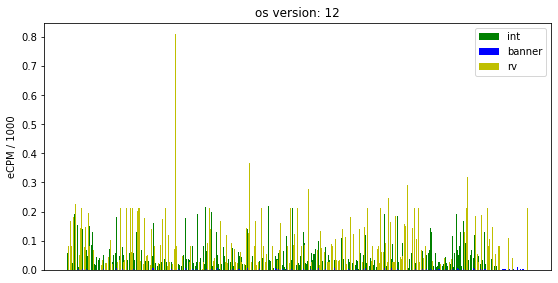

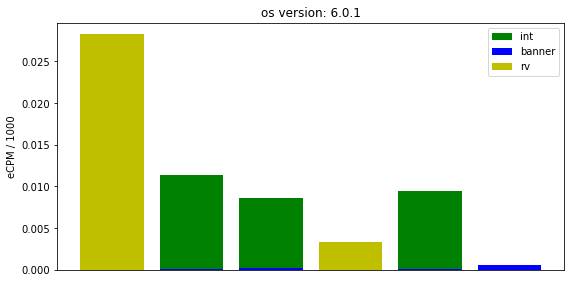

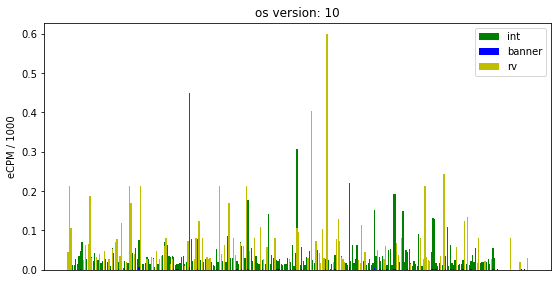

In [8]:
int_data_grouped_by_cities_and_os_mean = int_data[['os_version', 'city', 'revenue']].groupby(['os_version', 'city']).mean('revenue')
banner_data_grouped_by_cities_and_os_mean = banner_data[['os_version', 'city', 'revenue']].groupby(['os_version', 'city']).mean('revenue')
rv_data_grouped_by_cities_and_os_mean = rv_data[['os_version', 'city', 'revenue']].groupby(['os_version', 'city']).mean('revenue')

for os in set(data.os_version):
    try:
        x1 = int_data_grouped_by_cities_and_os_mean.loc[[os]].index.get_level_values(1)
        y1 = int_data_grouped_by_cities_and_os_mean.loc[[os]].revenue
    except:
        x1 = 0
        y1 = 0
        
    try:
        x2 = banner_data_grouped_by_cities_and_os_mean.loc[[os]].index.get_level_values(1)
        y2 = banner_data_grouped_by_cities_and_os_mean.loc[[os]].revenue
    except:
        x2 = 0
        y2 = 0
        
    try:
        x3 = rv_data_grouped_by_cities_and_os_mean.loc[[os]].index.get_level_values(1)
        y3 = rv_data_grouped_by_cities_and_os_mean.loc[[os]].revenue
    except:
        x3 = 0
        y3 = 0

    fig = plt.figure(figsize=(20, 10))
    ax = plt.subplot(2, 2, 1)
    try:
        if len(int_data_grouped_by_cities.loc[[os]].index.get_level_values(1)) > 8:
            ax.set(xticks=[], title='os version: ' + os, ylabel='eCPM / 1000')
        else:
            ax.set(title='os version: ' + os, ylabel='eCPM / 1000')
    except:
        ax.set(xticks=[], title='os version: ' + os, ylabel='eCPM / 1000')
    int_ = ax.bar(x1, y1, color='g', label='int')
    banner_ = ax.bar(x2, y2, color='b', label='banner')
    rv_ = ax.bar(x3, y3, color='y', label='rv')
    
    ax.legend()

    plt.show()

#### 1.C. Отобразить суммарные доходы по городам и версиям ОС для каждого формата рекламы.

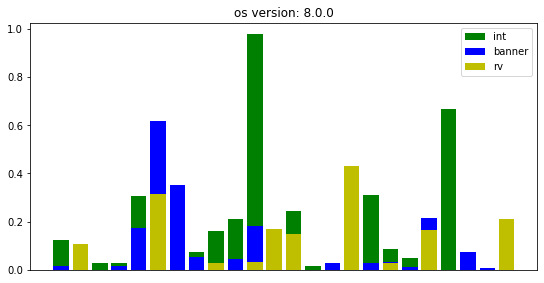

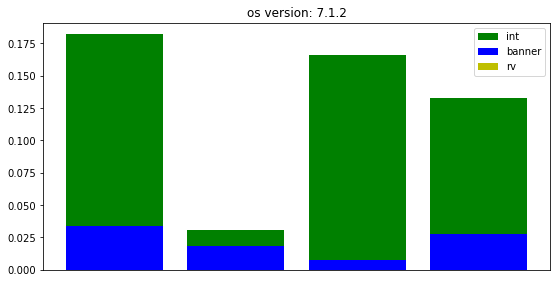

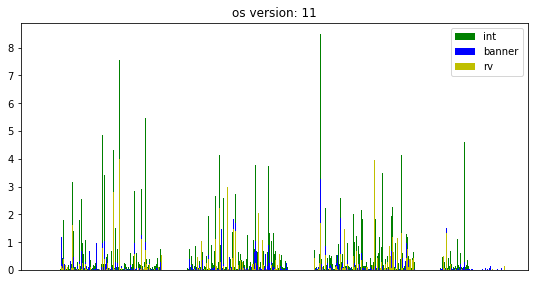

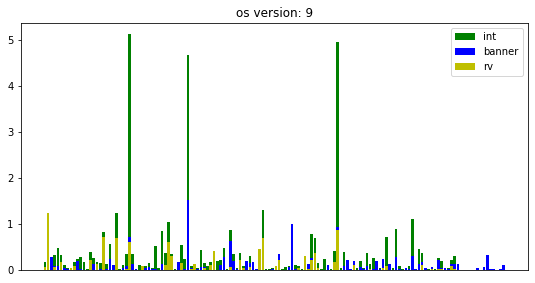

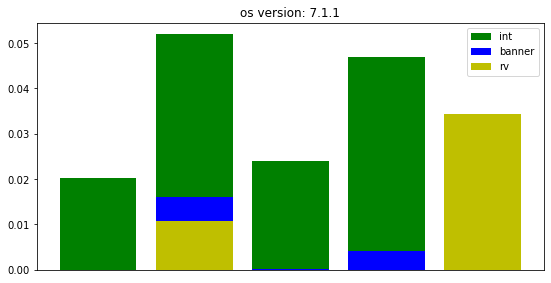

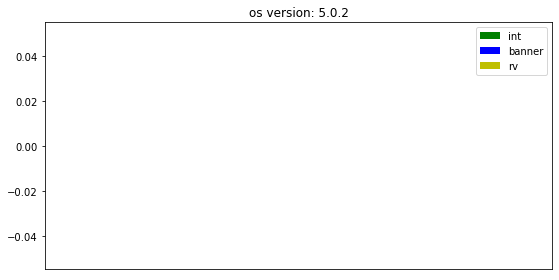

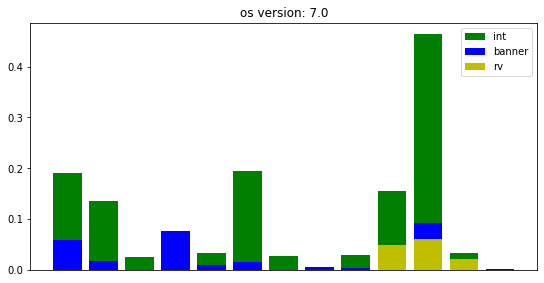

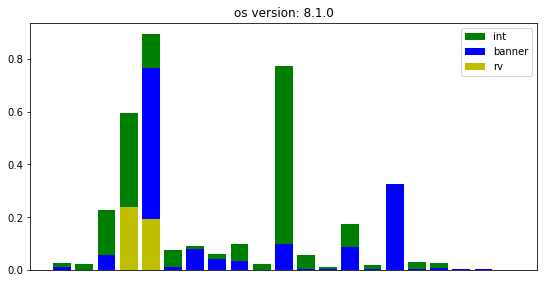

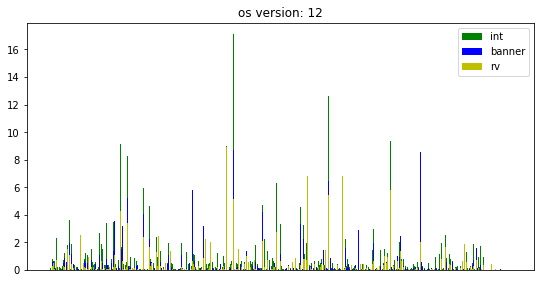

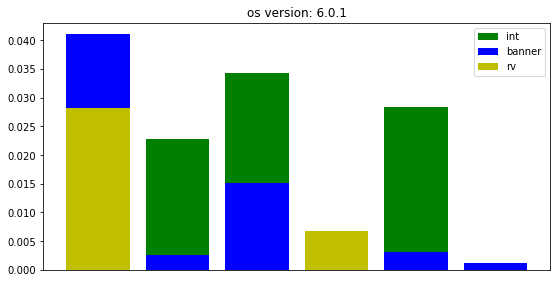

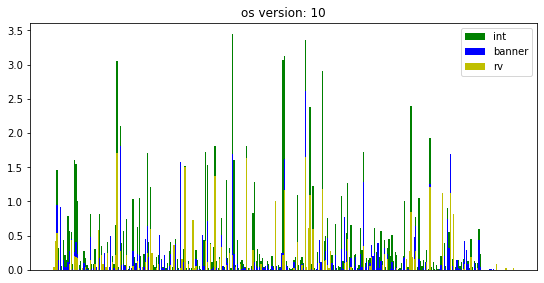

In [9]:
int_data_grouped_by_cities_and_os_sum = int_data[['os_version', 'city', 'revenue']].groupby(['os_version', 'city']).sum('revenue')
banner_data_grouped_by_cities_and_os_sum = banner_data[['os_version', 'city', 'revenue']].groupby(['os_version', 'city']).sum('revenue')
rv_data_grouped_by_cities_and_os_sum = rv_data[['os_version', 'city', 'revenue']].groupby(['os_version', 'city']).sum('revenue')

for os in set(data.os_version):
    try:
        x1 = int_data_grouped_by_cities_and_os_sum.loc[[os]].index.get_level_values(1)
        y1 = int_data_grouped_by_cities_and_os_sum.loc[[os]].revenue
    except:
        x1 = 0
        y1 = 0
        
    try:
        x2 = banner_data_grouped_by_cities_and_os_sum.loc[[os]].index.get_level_values(1)
        y2 = banner_data_grouped_by_cities_and_os_sum.loc[[os]].revenue
    except:
        x2 = 0
        y2 = 0
        
    try:
        x3 = rv_data_grouped_by_cities_and_os_sum.loc[[os]].index.get_level_values(1)
        y3 = rv_data_grouped_by_cities_and_os_sum.loc[[os]].revenue
    except:
        x3 = 0
        y3 = 0

    fig = plt.figure(figsize=(20, 10))
    ax = plt.subplot(2, 2, 1)
    try:
        if len(int_data_grouped_by_cities.loc[[os]].index.get_level_values(1)) > 8:
            ax.set(xticks=[], title='os version: ' + os, ylabel='eCPM / 1000')
        else:
            ax.set(title='os version: ' + os, ylabel='eCPM / 1000')
    except:
        ax.set(xticks=[], title='os version: ' + os)
    int_ = ax.bar(x1, y1, color='g', label='int')
    banner_ = ax.bar(x2, y2, color='b', label='banner')
    rv_ = ax.bar(x3, y3, color='y', label='rv')
    
    ax.legend()

    plt.show()

### Выводы   


In [10]:
print('Реклама формата int')
print('profile_id: ' + int_data_grouped_by_profile_id[int_data_grouped_by_profile_id.revenue == max(int_data_grouped_by_profile_id.revenue)].index[0])
print(f'max: {max(int_data_grouped_by_profile_id.revenue)}, mean: {int_data_grouped_by_profile_id.revenue.mean()}')
print()

print('Реклама формата banner')
print('profile_id: ' + banner_data_grouped_by_profile_id[banner_data_grouped_by_profile_id.revenue == max(banner_data_grouped_by_profile_id.revenue)].index[0])
print(f'max: {max(banner_data_grouped_by_profile_id.revenue)}, mean: {banner_data_grouped_by_profile_id.revenue.mean()}')
print()

print('Реклама формата rv')
print('profile_id: ' + rv_data_grouped_by_profile_id[rv_data_grouped_by_profile_id.revenue == max(rv_data_grouped_by_profile_id.revenue)].index[0])
print(f'max: {max(rv_data_grouped_by_profile_id.revenue)}, mean: {rv_data_grouped_by_profile_id.revenue.mean()}')

Реклама формата int
profile_id: JLs8H01mzVe
max: 0.5686782703125, mean: 0.04555745655201968

Реклама формата banner
profile_id: JMALx7q70qG
max: 0.0430213872291138, mean: 0.001157110755169167

Реклама формата rv
profile_id: JLtY7hvRXO3
max: 0.8082948201497396, mean: 0.08050200374719431


Реклама формата rv стоит гораздо больше, причем чаще встречаются пользователи, которые приносят бОльшый заработок 

Из второй группы графиков видно, что rv реклама опять-таки преобладает над остальными, однако не во всех городах пользователи пользуются этой рекламой

Из третьей группы графиков уже можно увидеть, что rv реклама хоть и имеет большее среднее значение дохода, однако реклама int встречается чаще, и поэтому доход от нее гораздо больше  

#### Дополнительно

1. Какой процент доходов содержит информацию о городе юзера?

In [11]:
1 - data[data.city.isnull()].revenue.sum() / data.revenue.sum()

0.6357509823694545

Следовательно, 63.6% доходов содержит информацию о городе юзера

2. Зависит ли eCPM от времени дня?

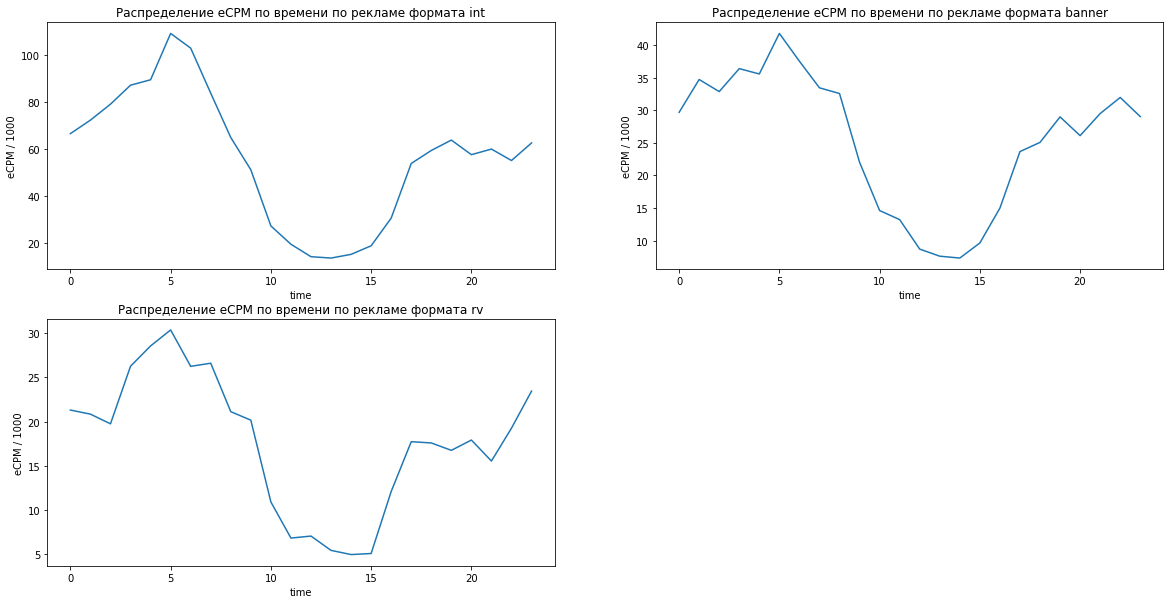

In [12]:
int_data_grouped_by_time = int_data[['time', 'revenue']].dropna().groupby('time').sum('revenue')
banner_data_grouped_by_time = banner_data[['time', 'revenue']].dropna().groupby('time').sum('revenue')
rv_data_grouped_by_time = rv_data[['time', 'revenue']].dropna().groupby('time').sum('revenue')

x1 = int_data_grouped_by_time.index
y1 = int_data_grouped_by_time.revenue

x2 = banner_data_grouped_by_time.index
y2 = banner_data_grouped_by_time.revenue

x3 = rv_data_grouped_by_time.index
y3 = rv_data_grouped_by_time.revenue

fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)

ax1.set(title='Распределение eCPM по времени по рекламе формата int', xlabel='time', ylabel='eCPM / 1000')
ax1.plot(x1, y1)

ax2.set(title='Распределение eCPM по времени по рекламе формата banner', xlabel='time', ylabel='eCPM / 1000')
ax2.plot(x2, y2)

ax3.set(title='Распределение eCPM по времени по рекламе формата rv', xlabel='time', ylabel='eCPM / 1000')
ax3.plot(x3, y3)

plt.show()

Основной пик заработка от рекламы попадает на время около 5 утра. Дальше до 15 дня он понижается и после - начинает расти.